# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 5: Predicting College Admissions

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai

<hr style="height:2.4pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
# RUN THIS CELL
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS


- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models [16 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Interpretable modeling [18 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Harvard and Yale? [30 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Building predictive models for admitted [24 pts]**](#part4)
  - [Solutions](#part4solutions)


- [**Question 5: Evaluating results [12 pts]**](#part5)
  - [Solutions](#part5solutions)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges (one is elite at least :) ): Harvard and Yale.  The data are provided in the file `data/college_admissions.csv` and were scraped from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **school**: a categorical variable for school applied to: "Harvard" or "Yale"
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "school", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models, and you will be replacing the `"school"` variable with a binary `"harvard"` variable early in the questions below.

Please use this dataset to answer the following questions below.

**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty="none"`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models [16 pts]</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?


**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?


**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).


**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?


In [3]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################

college = pd.read_csv("data/college_admissions.csv")
np.random.seed(121)

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["school"],
)

print(college.shape)
print(college_train.shape, college_test.shape)

(1871, 16)
(1496, 16) (375, 16)


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What proportion of observations were admitted overall?  What would be the train and test classification accuracies for a baseline "naive" model where we classified ALL applicants as either admitted or not admitted using just this overall proportion to make our decision (i.e. we apply the same outcome to all applicants based on this proportion)?
    
</div>

In [4]:
# your code here
college_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1496 entries, 584 to 1537
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test           1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  school         1496 non-null   object 
 12  early_app      1496 non-null   int64  
 13  alumni         1496 non-null   int64  
 14  program        1294 non-null   object 
 15  add_info       933 non-null    object 
dtypes: float64(2), int64(10), object(4)
memory usage: 198.7+ KB


In [5]:
# your code here
# separate X and y matrices
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"] 
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

In [6]:
# your code here
n_train = len(y_train)
n_admitted_train = y_train.sum()
prop_admitted_train = n_admitted_train / n_train
accuracy_naive_model_train = 1 - prop_admitted_train

n_test = len(y_test)
n_admitted_test = y_test.sum()
prop_admitted_test = n_admitted_test / n_test
accuracy_naive_model_test = 1 - prop_admitted_test

print(
    "Of the {:,} training observations in this dataset, "
    "{:.4f} (i.e. {:,}) were admitted.\n".format(
        n_train, prop_admitted_train, n_admitted_train
    )
)

print(
    "Because this proportion is below 0.5, for our 'naive' "
    "model, we would predict no applicants are admitted, "
    "resulting in a baseline training accuracy of:\n\n\t"
    "Training accuracy\t1 - {:.4f} = {:.4f}\n".format(
        prop_admitted_train, accuracy_naive_model_train
    )
)

print(
    "Using this same 'naive' model on our TEST data (i.e. "
    "if we were to predict all applicants as NOT admitted):"
    "\n\n\tTEST accuracy\t1 - {:.4f} = {:.4f}".format(
        prop_admitted_test, accuracy_naive_model_test
    )
)

Of the 1,496 training observations in this dataset, 0.2627 (i.e. 393) were admitted.

Because this proportion is below 0.5, for our 'naive' model, we would predict no applicants are admitted, resulting in a baseline training accuracy of:

	Training accuracy	1 - 0.2627 = 0.7373

Using this same 'naive' model on our TEST data (i.e. if we were to predict all applicants as NOT admitted):

	TEST accuracy	1 - 0.2987 = 0.7013


<div class='exercise-r'>

**1.2** Create a binary ("dummy") variable named `"harvard"` that takes on the value 1 if `school == "Harvard"` and 0 otherwise. Now, explore the marginal association of each of our 12 predictors with whether or not an applicant is admitted into the college to which they applied (`admitted`). Create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a *matrix* of subplots with 3 columns and 4 rows.

**NOTE:** We will be using our dummified `harvard` predictor instead of `school` throughout the remainder of this problem set.
    
</div>

In [7]:
# your code here
bool_array_admitted = (y_train == 1)

X_train["harvard"] = (X_train["school"] == "Harvard").astype(int)
X_test["harvard"] = (X_test["school"] == "Harvard").astype(int)

predictor_list = [
    "test", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

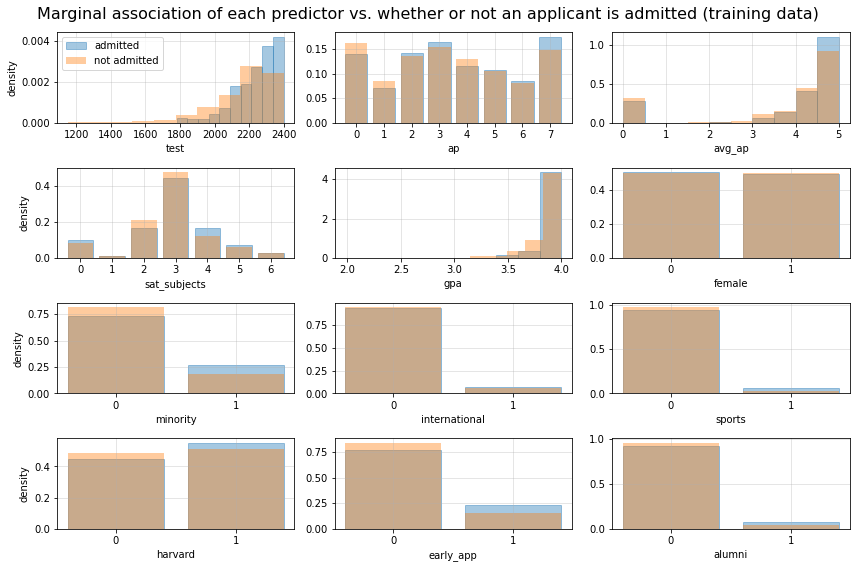

In [8]:
# your code here

# identify which predictors should be plotted using histogram (others will be barplots)
hist_list = ["test", "avg_ap", "gpa"]
n_notadmitted_train = n_train - n_admitted_train

# generate plot
fig, axes = plt.subplots(4,3, sharey=False, figsize=(12,8))

plt.suptitle(
    "Marginal association of each predictor vs. whether or "
    "not an applicant is admitted (training data)",
    fontsize=16,
)

for i, (ax, predictor) in enumerate(zip(axes.flat, predictor_list)):
    # make subplot historgram if predictor is in hist_list
    if predictor in hist_list:
        ax.hist(
            X_train[predictor][bool_array_admitted],
            density=True, edgecolor="tab:blue", alpha=0.4, label="admitted"
        )
        ax.hist(
            X_train[predictor][~bool_array_admitted],
            density=True, alpha=0.4, label="not admitted"
        )
    # otherwise plot as barplot
    else:
        # generate value counts for plotting (for both admitted and not admitted)
        pred_count_admit = X_train[predictor][bool_array_admitted].value_counts().sort_index()
        pred_count_notadmit = X_train[predictor][~bool_array_admitted].value_counts().sort_index()
        pred_vals_admit = pred_count_admit.index
        pred_vals_notadmit = pred_count_notadmit.index
        # when plotting bars divide by total n to convert counts to densities
        ax.bar(
            pred_vals_admit,
            pred_count_admit / n_admitted_train,
            edgecolor="tab:blue", alpha=0.4, label="admitted"
        )
        ax.bar(
            pred_vals_notadmit,
            pred_count_notadmit / n_notadmitted_train,
            alpha=0.4, label="not admitted"
        )
        ax.set_xticks(pred_vals_notadmit)
    ax.set_xlabel(predictor)
    ax.set_ylabel("density" if i%3==0 else None)
    ax.grid(":", alpha=0.4)
    if i==0:
        ax.legend()
    
plt.tight_layout()
plt.show()

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    
</div>

*your answer here*

There are several variables that could be argued as having the most potential (e.g. `test`, `avg_ap`, `ap`, `early_app`, and `minority` appear to be the strongest choices) based on a set of successful plots in Question 1.2. Students should make it clear that they gave careful consideration to the plotted values and decided based on differences between marginal association/distribution among admitted and non-admitted students.

**Solution notes (for student reference):**

By plotting distribution densities of "admitted" overlayed with "not-admitted" for each predictor, we can begin to see which predictors have the largest shift in density among admitted vs. not-admitted outcomes. For instance, notice the notable shifts for `test` observations or `minority` observations, which can help to signal how well those variables might work for predicting outcomes. In fact, the above plots could perhaps be improved even more by plotting 2 vertical lines on each subplot to illustrate the mean values for admitted and non-admitted (each represented by its own line) specific to each predictor to further illustrate these shifts in density.

These visual comparisons become far more difficult if we:

1. Start varying plot types by predictor, such as boxplots vs. barplots (luckily histograms and barplots are analogous enough to preserve direct visual comparison);
2. Fail to plot both admitted and non-admitted distributions together (then it becomes far more difficult and often impossible to notice these changes/shifts in marginal association);
3. Use counts instead of densities for our histograms or barplots, because the imbalance between outcome classes (i.e. far fewer admitted than not-admitted observations) visually obscures actual shifts in density.

<div class='exercise-r'>
    
**1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  Interpret the coefficient estimates: which college is estimated to be easier to get into?  What are the estimated probabilities of getting into each school?
    
</div>

In [9]:
# your code here

# Fit logistic regression model without regularization
penalty = "none"

logit1_4 = LogisticRegression(penalty=penalty).fit(
    X_train["harvard"].values.reshape(-1, 1), y_train.values
)

# Identify and report coefficients
logit1_4_coefs = logit1_4.coef_[0]
logit1_4_intercept = logit1_4.intercept_

print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coefs[0], logit1_4_intercept[0]
    )
)

# Calculate and report probabilities. The formula
# used here is described in the markdown cell below
p_harvard = 1 / (
    1 + np.exp(-(logit1_4_intercept[0] + logit1_4_coefs[0]))
)
p_yale = 1 / (
    1 + np.exp(-(logit1_4_intercept[0]))
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.1532 and the intercept is -1.1137

Estimated probability of acceptance for Harvard: 0.2768
Estimated probability of acceptance for Yale: 0.2472


**INTERPRETATION:**

*your answer here*

Since the coefficient for the 'harvard' predictor is positive, it means that applying to Harvard positively contributes to chances of admissions relative to applying to Yale. More precisely, the actual coefficient value tells us that an application to Harvard will have a 0.1532 increase in log-odds of admission versus an application to Yale. Therefore, our model is telling us that Harvard is easier to get accepted to than Yale. 

The probability for a logistic regression with one variable is:

$$P(Y=1) = \frac{1}{1+e^{-(\beta_0+\beta_1X_1)}}$$

So, as is calculated in the code cell above, for each school we get:

$$P(admitted=1|harvard=1) = \frac{1}{1+e^{-(-1.1137+.1532)}} = 0.2768$$

$$P(admitted=1|harvard=0) = \frac{1}{1+e^{-(-1.1137)}} = 0.2472$$


<div class='exercise-r'>

**1.5** Create a contingency table between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope).

</div>

In [10]:
# your code here

# first we generate our contingency table
logit1_4_conting_table = pd.crosstab(
    y_train, X_train["school"], margins=True
)

# then we calculate the probability of admission for 
# both harvard and yale applicants
prop_harv_admit = (
    logit1_4_conting_table["Harvard"][1] / 
    logit1_4_conting_table["Harvard"]["All"]
)
prop_yale_admit = (
    logit1_4_conting_table["Yale"][1] / 
    logit1_4_conting_table["Yale"]["All"]
)

# then we calculate beta_0 using log-odd of yale admission
# (see written explanation below)
beta_0 = np.log( prop_yale_admit / (1- prop_yale_admit) )

# finally we calculate beta_1 using beta_0 and our harvard log-odds
beta_1 = np.log( prop_harv_admit / (1- prop_harv_admit) ) - beta_0

print(
    "The contingency table between admitted and Harvard is:"
    "\n\n{}\n".format(logit1_4_conting_table)
)

print(
    "And our estimated beta_0 and beta_1 coefficients calculated using the "
    "values of this contingency table (and the method described below) are:"
    "\n\n\tbeta_0\t{:.4f}\n\tbeta_1\t{:.4f}".format(
        beta_0, beta_1
    )
)


The contingency table between admitted and Harvard is:

school    Harvard  Yale   All
admitted                     
0             567   536  1103
1             217   176   393
All           784   712  1496

And our estimated beta_0 and beta_1 coefficients calculated using the values of this contingency table (and the method described below) are:

	beta_0	-1.1137
	beta_1	0.1532


*your answer here*

**Because we are dealing with one binary predictor $X$, logistic regression provides a convenient closed-form solution to solve for $\beta_0$ and $\beta_1$.**

Based on the contingency table above, we can see that the probability of being admitted for Harvard applicants in $217 \: / \: 784 \approx 0.2768$ and the probability of being admitted for Yale applicants is $176 \: / \: 712 \approx 0.2472$, which both agree with the estimated probabilities provided by our model in question 1.4 above.

Now, if we remember the following log-odds representation of a logistic regression model with only one $X$ predictor:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 $$

We can see that the $\beta_1 X_1$ term is just $\beta_1$ for Harvard applicants (because $X_1 = 1$) and $0$ for Yale applicants (because $X_1 = 0$).

Therefore, the estimated intercept $\beta_0$ can be solved using the probability of being admitted for a Yale applicant:

$$
\begin{split}
\hat{\beta_0} & = \ln \left( \frac{P(Y=1 | X_1 = 0)}{1-P(Y=1 | X_1 = 0)} \right) \\
& = \ln \left( \frac{0.2472}{1-0.2472} \right) \\
& = -1.1136
\end{split}
$$

And then, the estimated slope $\beta_1$ can be solved using our estimated $\beta_0$ and the probability of being admitted for a Harvard applicant:

$$
\begin{split}
\hat{\beta_0} + \hat{\beta_1} & = \ln \left( \frac{P(Y=1 | X_1 = 1)}{1-P(Y=1 | X_1 = 1)} \right) \\
\hat{\beta_1} & = \ln \left( \frac{0.2768}{1-0.2768} \right) - \hat{\beta_0} \\
& = \ln \left( \frac{0.2768}{1-0.2768} \right) + 1.1136 \\
& = 0.1532
\end{split}
$$

Both of these estimated intercepts agree with the intercepts we generated using `sklearn` in question 1.4.

<div class='exercise-r'>

**1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2023-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

*your answer here*

Students should point out that admissions rates identified in our data are much higher than the actual admissions rates, and that Harvard appears to have a lower actual acceptance rate than Yale (which is opposite of the relationship in our data). Answers should point out that the source of our data is biased and not reliable, primarily as a result of self-reporting, and is thus not representative of the true population of applicants. For instance, applicants who were actually admitted are likely more willing to have reported their information for inclusion in our dataset. Whereas, the "Overall Acceptance Rate" reported on the website would likely have come from actual admissions metrics reported directly by each university.

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling [18 pts]</div>

[Return to contents](#contents)

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data). 

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?

**2.3**  Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data). 

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.


<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Fit a logistic regression model to predict `admitted` from `test` alone (call it `logit2_1`).  Print out the coefficient estimates (remember to always print both intercept and slope coefficients) along with the classification accuracies for this model (on both train and test data).
    
</div>

In [11]:
# your code here
logit2_1_predictors = ["test"]

logit2_1 = LogisticRegression(penalty=penalty).fit(
    X_train[logit2_1_predictors].values.reshape(-1, 1), y_train.values
)

logit2_1_coefs = logit2_1.coef_[0]
logit2_1_intercept = logit2_1.intercept_

accuracy_train_logit2_1 = logit2_1.score(
    X_train[logit2_1_predictors].values.reshape(-1, 1), y_train
)
accuracy_test_logit2_1 = logit2_1.score(
    X_test[logit2_1_predictors].values.reshape(-1, 1), y_test
)

print(
    "The intercept and coefficient for the 'logit2_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit2_1_intercept[0]
    )
)

for predictor, coef in zip(logit2_1_predictors, logit2_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        accuracy_train_logit2_1, accuracy_test_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:

	intercept           -9.4136
	test                0.0038

The classification accuracies for 'logit2_1' are:

	Train	0.7373
	TEST	0.7013


<div class='exercise-r'>

**2.2** What is the estimated probability of an applicant being admitted with an *average* `test` score of 2250?  What about if they had a perfect test score of 2400?  What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted?
    
</div>

In [12]:
# your code here

# calculate probabilities for 2250 and 2400 directly using model
prob_test_2250 = logit2_1.predict_proba([[2250]])[0,1]
prob_test_2400 = logit2_1.predict_proba([[2400]])[0,1]

# calculate test score required for 50/50 prob as per the
# formula shown in the markdown cell below
test_50_50 = -logit2_1_intercept[0] / logit2_1_coefs[0]

# your code here
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.2929
	2400	0.4226

The test score required to have a 50-50 chance of being admitted is approximately:

	2482.34


*your answer here*

In order to calculate the precise test score needed to have a 50-50 chance of being admitted (as is reported above), we needed to first solve for $x$ where:

$$
\begin{split}
\ln\left(\frac{0.5}{1-0.5}\right) & = \beta_0 + \beta_1 x \\
0 & = \beta_0 + \beta_1 x \\
\beta_1 x & = -\beta_0 \\
x & = - \frac{\beta_0}{\beta_1}
\end{split}
$$

<div class='exercise-r'>

**2.3** Fit a logistic regression model to predict `admitted` from `test` and `avg_ap` (call it `logit2_3`).  Print out the coefficient estimates along with the classification accuracies for this model (on both train and test data).
    
</div>

In [13]:
# your code here
logit2_3_predictors = ["test", "avg_ap"]

logit2_3 = LogisticRegression(penalty=penalty).fit(
    X_train[logit2_3_predictors].values, y_train.values
)

logit2_3_coefs = logit2_3.coef_[0]
logit2_3_intercept = logit2_3.intercept_

accuracy_train_logit2_3 = logit2_3.score(
    X_train[logit2_3_predictors].values, y_train
)
accuracy_test_logit2_3 = logit2_3.score(
    X_test[logit2_3_predictors].values, y_test
)

print(
    "The intercept and coefficients for the 'logit2_3' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit2_3_intercept[0]
    )
)

for predictor, coef in zip(logit2_3_predictors, logit2_3_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit2_3, accuracy_test_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:

	intercept           -0.0188
	test                -0.0005
	avg_ap              0.0533

The classification accuracies for 'logit2_3' are:

	Train	0.7373
	TEST	0.7013


<div class='exercise-r'>

**2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test` to the one from `logit2_1`.  Why has this estimate changed?

**HINT:** You may want to inspect the relationship between `test` and `avg_ap` to help get a better sense for what might be happening here.

</div>

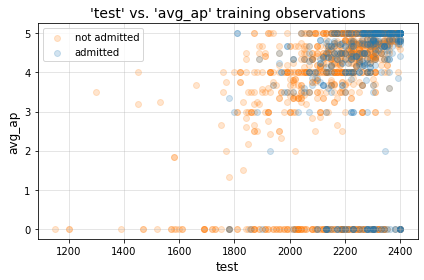

In [14]:
# your code here
plt.title("'test' vs. 'avg_ap' training observations", fontsize=14)

plt.scatter(
    X_train["test"][~bool_array_admitted],
    X_train["avg_ap"][~bool_array_admitted],
    alpha=0.2,
    label="not admitted",
    color="tab:orange",
)
plt.scatter(
    X_train["test"][bool_array_admitted],
    X_train["avg_ap"][bool_array_admitted],
    alpha=0.2,
    label="admitted",
    color="tab:blue",
    edgecolor="tab:blue",
)

plt.legend()
plt.xlabel("test", fontsize=12)
plt.ylabel("avg_ap", fontsize=12)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show()

**INTERPRETATION:**

*your answer here*

Students should directly interpret the coefficients in `logit2_3`, point out how the `test` coefficient has changed between models, and provide accurate reasoning for this change.

For instance, based on `logit2_3`, a one point increase in test score results in a 0.0005 REDUCTION in predicted log-odds of being admitted while holding all other predictors constant; and every one point increase in average score on an applicant's AP tests contributes to a 0.0533 increase in predicted log-odds for admission while holding all other predictors constant. In contrast, in our `logit2_1` model, a one point increase in test score was associated with a 0.0038 INCREASE in predicted log-odds of being admitted.

This shift from a positive to a negative relationship between `test` and the probability of admission is a result of the collinear relationship between the predictors `test` and `avg_ap` (as is illustrated in the scatterplot above). By introducing a collinear predictor into a regression model, our affected coefficients for that model are no longer uniquely determined. This hurts the interpretability of the model and can cause large swings such as this in the coefficients for our collinear predictors.

<div class='exercise-r'>

**2.5** Interpret and compare the classification accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

*your answer here*

Students should point out that the classification scores are the same. 

Reasonable explanations could include that test scores and average AP scores do not provide information that is unique to themselves due to their moderate collinearity. Also, and very importantly, as stated in the data overview at the start of this notebook, AP scores are set to 0 for missing observations (which explains the many zero-valued AP observations in our Question 2.4 plot above). This likely further contributes to AP not providing enough additional information to improve our predictions here. 

It should also be noted that the accuracies here are no better than the naive model we initially proposed. If we were to inspect our actual predicted class values in our 2 logistic regression models here, we would see that all observations are still just predicted to be Class 0 (i.e. not admitted). This is because the data has heavily imbalanced classes (i.e. far more Class 0 observations than Class 1 observations), so getting $\hat{p}>.5$ is difficult for a model to achieve. Therefore these models have returned NO class 1 predictions. This is a very real and very important problem to be aware of when fitting logistic regression models on imbalanced data.

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale? [30 pts]</div>

[Return to contents](#contents)

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$

**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"]`.  Output and interpret the coefficient estimates for the binary predictors in this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [15]:
# your code here
logit3_1_predictors = [
    "harvard", "test", "ap", "avg_ap", "gpa", "female", "minority"
]
max_iter = 1000

logit3_1 = LogisticRegression(penalty=penalty, max_iter=max_iter).fit(
    X_train[logit3_1_predictors].values, y_train.values
)

logit3_1_coefs = logit3_1.coef_[0]
logit3_1_intercept = logit3_1.intercept_

accuracy_train_logit3_1 = logit3_1.score(
    X_train[logit3_1_predictors].values, y_train
)
accuracy_test_logit3_1 = logit3_1.score(
    X_test[logit3_1_predictors].values, y_test
)

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept[0]
    )
)

for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit3_1, accuracy_test_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -1.1670
	harvard             0.1408
	test                0.0030
	ap                  -0.0202
	avg_ap              0.0313
	gpa                 -1.7331
	female              -0.0268
	minority            0.4504

The classification accuracies for 'logit3_1' are:

	Train	0.7320
	TEST	0.7013


**INTERPRETATION:**

*your answer here*

These coefficients indicate that applying to Harvard or being a minority each positively contribute to chances of admission while holding all other predictors constant. More precisely, Harvard applicants have a 0.1408 increase in log-odds of admission while holding other predictors constant, while minority applicants have a 0.4505 increase while holding other predictors constant.

Meanwhile, according to this model, being a female lowers an applicant's log-odds by 0.0268 while holding all other predictors constant.

**PLEASE NOTE:** 

These interpretations will vary dependent on the computational results above.

The results for Q3.1 can vary depending on the machine/OS (mac, windows, linux, etc.) used to fit the regression model. Strangely both sets of results appear to be stable (and do not change) dependent on the machine/OS used. For lack of a better explanation, this could possibly mean that there are multiple sets of competing (and similarly desirable) local minima for this problem's loss function.

Please be aware that, because of this phenomenon, some results could correctly show coefficients and scores closer to these:

```
intercept   -12.7245
harvard     0.1382
test        0.0045
ap          -0.0495
avg_ap      0.0096
gpa         0.4084
female      0.0219
minority    0.8699

Train       0.7413
TEST        0.6987
```

This means that the signs of some coefficients could go either way (+/-) dependent on these computational results. **As such, this would lead to differing interpretations above.**

<div class='exercise-r'>

**3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test", "ap"]` along with the 2 interaction terms: `harvard` with `test` and `harvard` with `ap`. Name the columns for these interaction terms something sensible.  Print out the coefficient estimates for this model.

</div>

In [16]:
# your code here
# Create interaction terms
X_train["harvard_test"] = X_train["harvard"] * X_train["test"]
X_train["harvard_ap"] = X_train["harvard"] * X_train["ap"]


logit3_2_predictors = [
    "harvard", "test", "ap", "harvard_test", "harvard_ap"
]
max_iter = 1000

logit3_2 = LogisticRegression(penalty=penalty, max_iter=max_iter).fit(
    X_train[logit3_2_predictors].values, y_train.values
)

logit3_2_coefs = logit3_2.coef_[0]
logit3_2_intercept = logit3_2.intercept_

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept[0]
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))


The intercept and coefficients for the 'logit3_2' model are:

	intercept           -7.1344
	harvard             -4.4410
	test                0.0027
	ap                  0.0240
	harvard_test        0.0022
	harvard_ap          -0.1101


<div class='exercise-r'>

**3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants: (1) someone who is applying to Harvard and for (2) someone who is applying to Yale (keep `test` and `ap` as the unknown $X$s).  The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$.

</div>

*your answer here*

Using the basic logistic regression framework shown above, the model statements for the 2 applicants can be written as such, where:

* $\beta_0$ is the model intercept
* $\beta_1 X_1$ are the slope and value for `harvard`
* $\beta_2 X_2$ are the slope and value for `test`
* $\beta_3 X_3$ are the slope and value for `ap`
* $\beta_4 X_4$ are the slope and value for interaction term $X_1 \cdot X_2$ 
* $\beta_5 X_5$ are the slope and value for interaction term $X_1 \cdot X_3$

The applicant applying to Harvard (i.e. $X_1= 1$) can be expressed as:

$$
\begin{split}
\ln \left( \frac{P(Y=1 | X_1 = 1)}{1-P(Y=1 | X_1 = 1)} \right) & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 \\
& = -7.1344 - 4.4410 \cdot X_1 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3 + 0.0022 \cdot X_2\cdot X_1 - 0.1101 \cdot X_3 \cdot X_1 \\ \\
& = -7.1344 - 4.4410 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3 + 0.0022 \cdot X_2 - 0.1101 \cdot X_3 \\
\\
& = −11.5754 + 0.0049 \cdot X_2 - 0.0861 \cdot X_3 \\ \\
\end{split}
$$

And, the applicant applying to Yale (i.e. $X_1= 0$), where all terms multiplied by the `harvard` variable $X_1$ can be zeroed out, can be expressed as:

$$
\begin{split}
\ln \left( \frac{P(Y=1 | X_1 = 0)}{1-P(Y=1 | X_1 = 0)} \right) & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 \\
& = -7.1344 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3
\end{split}
$$

<div class='exercise-r'>

**3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied (each college is associated with a different function)? If a student scored a perfect 2400 on `test`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

</div>

*your answer here*

If we can define our classification boundary where $P(Y=1)=0.5$ as such:

$$
\begin{split}
\ln\left(\frac{0.5}{1-0.5}\right) = 0 & = -7.1344 - 4.4410 \cdot X_1 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3 + 0.0022 \cdot X_2\cdot X_1 - 0.1101 \cdot X_3 \cdot X_1 \\ \\
\end{split}
$$

Then, for **Harvard** applicants, we can express the range of values of `test` as a function of `ap`, as such:

$$
\begin{split}
0 & = -7.1344 - 4.4410 \cdot 1 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3 + 0.0022 \cdot X_2\cdot 1 - 0.1101 \cdot X_3 \cdot 1 \\ \\
- 0.0027 \cdot X_2 - 0.0022 \cdot X_2 & = -7.1344 - 4.4410 + 0.0240 \cdot X_3 - 0.1101 \cdot X_3 \\ \\
-0.0049 \cdot X_2 & = -11.5754 - 0.0861 \cdot X_3 \\ \\
X_2 & = \frac{11.5754 + 0.0861 \cdot X_3}{0.0049} \\ \\
X_2 & = 2362.32 + 17.57 \cdot X_3
\end{split}
$$

And, for **Yale** applicants, as such:

$$
\begin{split}
0 & = -7.1344 - 4.4410 \cdot 0 + 0.0027 \cdot X_2 + 0.0240 \cdot X_3 + 0.0022 \cdot X_2\cdot 0 - 0.1101 \cdot X_3 \cdot 0 \\ \\
- 0.0027 \cdot X_2 & = -7.1344 + 0.0240 \cdot X_3 \\ \\
X_2 & = \frac{7.1344 - 0.0240 \cdot X_3}{0.0027} \\ \\
X_2 & = 2642.37 - 8.89 \cdot X_3
\end{split}
$$

So for an applicant to Harvard with a test score of 2400, the number of ap tests would solve to:

$$
\begin{split}
2400 & = 2362.32 + 17.57 \cdot X_3 \\ \\
X_3 & = 2.14
\end{split}
$$

However, the inequality in this case works out that 2.14 is the **maximum** number of ap tests the student can take. The interaction term of `harvard_ap` is a larger negative coefficient than `ap` is positive. So, according to our model, having a higher number of ap tests actually lowers an applicant's chances of being admitted to Harvard. This result is counterintuitive to what we would expect to see here.

<div class='exercise-r'>

**3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous part.  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see.
    
</div>

In [17]:
# your code here
def boundary_values_test(ap_value_array, harvard):
    """
    Takes 'ap' values as input (single values or 1D arrays) and bool or 0,1
    value indicating whether or not applicant is applying to 'harvard'
    and returns corresponding 'test' values for the classification boundary
    """
    if harvard:
        return 2362.32 + 17.57 * ap_value_array
    else:
        return 2642.37 - 8.89 * ap_value_array

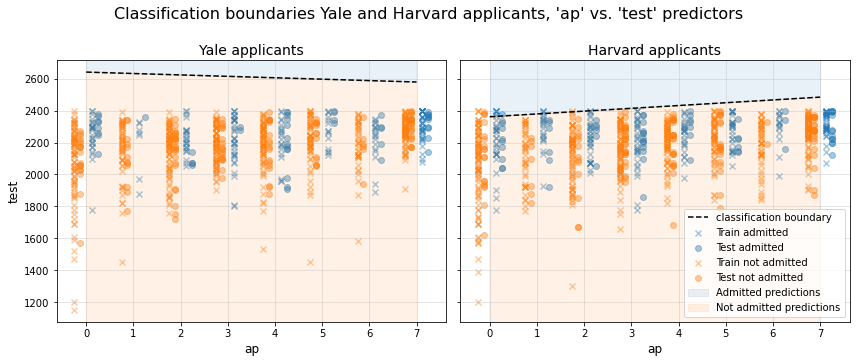

In [18]:
# your code here
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

def loc_filter(data, harvard, admit):
    return data.loc[
        (data["harvard"] == harvard) & (data["admitted"] == admit)
    ]
    
xoffset = 0.125
xarray = np.arange(0, 8)
alpha = 0.4
admit_color = "tab:blue"
noadmit_color = "tab:orange"

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))

plt.suptitle(
    "Classification boundaries Yale and Harvard applicants, "
    "'ap' vs. 'test' predictors",
    y=1,
    fontsize=16,
)

for i, ax in enumerate(axes.flat):
    ax.scatter(
        loc_filter(data_train, i, 1)["ap"]+ xoffset,
        loc_filter(data_train, i, 1)["test"],
        label="Train admitted",
        marker="x",
        alpha=alpha,
        color=admit_color,
    )
    ax.scatter(
        loc_filter(data_test, i, 1)["ap"]+ 2*xoffset,
        loc_filter(data_test, i, 1)["test"],
        label="Test admitted",
        alpha=alpha,
        color=admit_color,
    )
    ax.scatter(
        loc_filter(data_train, i, 0)["ap"]- 2*xoffset,
        loc_filter(data_train, i, 0)["test"],
        label="Train not admitted",
        marker="x",
        alpha=alpha,
        color=noadmit_color,
    )
    ax.scatter(
        loc_filter(data_test, i, 0)["ap"]-xoffset,
        loc_filter(data_test, i, 0)["test"],
        label="Test not admitted",
        alpha=alpha,
        color=noadmit_color,
    )
    ax.plot(
        xarray, boundary_values_test(xarray, harvard=i),
        "k--", label="classification boundary"
    )
    # set ylim based on plotted elements above
    ylim = ax.set_ylim()
    ax.set_ylim(ylim)
    
    # plot shaded decision regions
    ax.fill_between(
        xarray, 
        boundary_values_test(xarray, harvard=i),
        np.full(len(xarray), 3000),
        color=admit_color,
        alpha=0.1,
        label="Admitted predictions",
    )
    ax.fill_between(
        xarray, 
        boundary_values_test(xarray, harvard=i),
        np.full(len(xarray), 0),
        color=noadmit_color,
        alpha=0.1,
        label="Not admitted predictions",
    )

    ax.set_xlabel("ap", fontsize=12)
    ax.set_ylabel("test" if i==0 else None, fontsize=12)
    ax.set_title(
        "{} applicants".format("Harvard" if i==1 else "Yale"),
        fontsize=14
    )
    ax.grid(":", alpha=alpha)
    if i==1:
        ax.legend()

plt.tight_layout()
plt.show()

**INTERPRETATION:**

*your answer here*

Student interpretations should provide meaningful insight into the boundary line (particularly the slope of it by school) and the relationship between test and ap predictors. Considering what we know from our data, our naive model, and the challenge of improving predictions with our logistic classification models thus far, these improbable decision boundaries (i.e. unrealistic corresponding test scores) should not be too much of a surprise at this point and are reflective of these larger issues with our models and underlying data. As we can see from the plots above, there is no overlap between "admitted" predictions and observed (or even possible) test scores for Yale applicants. This means that, regardless of test score, all Yale applicants will be predicted as "not admitted" by our `logit3_2` model. Meanwhile, for Harvard applicants, there is slight overlap between our decision boundary and possible test scores. However, with the decision boundary's positive slope for Harvard applicants, once an applicant has taken greater than 2 AP tests, there is no possible test score at which our model will predict that applicant as "admitted". In fact, based on this model, a Harvard applicant's probability of admission continues to decrease as their number of AP tests increase.

<div class='exercise-r'>

**3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`.  Print out the coefficient estimates for this model.
    
</div>

In [19]:
# your code here
# Create interaction terms
X_train["harvard_female"] = X_train["harvard"] * X_train["female"]
X_train["harvard_minority"] = X_train["harvard"] * X_train["minority"]


logit3_6_predictors = [
    "harvard", "test", "female", "minority",
    "harvard_female", "harvard_minority"
]
max_iter = 1000

logit3_6 = LogisticRegression(penalty=penalty, max_iter=max_iter).fit(
    X_train[logit3_6_predictors].values, y_train.values
)

logit3_6_coefs = logit3_6.coef_[0]
logit3_6_intercept = logit3_6.intercept_

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept[0]
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))


The intercept and coefficients for the 'logit3_6' model are:

	intercept           -10.7207
	harvard             0.3636
	test                0.0042
	female              0.0113
	minority            1.4193
	harvard_female      0.0976
	harvard_minority    -1.0333


<div class='exercise-r'>

**3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

*your answer here*

Students need to correctly interpret the coefficients, particular the signs of the coefficients. They should also understand how interaction terms work with regard to whether the student applied to Harvard vs. Yale. For example, for the interaction terms, it appears that there is an additional positive effect for female applicants (a 0.0976 increase in log-odds), but a partial reduction in log-odds for minority applicants (a 1.0333 decrease in log-offs) when applying to Harvard relative to Yale (Yale being our reference group). 

We know this because, as we saw in Q3.3/Q3.4 derivations, both the female and minority coefficients can be summed with their corresponding interaction term coefficients to give the overall change in log-odds for Harvard applicants while holding all other predictors constant. Doing this, we can see that there are still overall increases in log-odds for both female and minority Harvard applicants. The minority applicants at Harvard just don't have as large an increase in their chances for admission as they do when applying to Yale because of the negative `harvard * minority` interaction coefficient (i.e. $1.4193 - 1.0333 = 0.386$ log-odds).

**PLEASE NOTE:**

Similar to Q3.1, the Q3.6 logistic model may also run into issues with different coefficients dependent on the machine/OS being used (unfortunately we were not able to recreate it for these solutions). Those different coefficients will affect this Q3.7 interpretation.

<div class='exercise-r'>

**3.8** Based on this sample, how does it appear that Harvard and Yale compare in admitting these groups?  Why would it be wrong to take this interpretation as truth?

</div>

*your answer here*

It should be understood (whether here or in the rest of the problem), that the Harvard predictor can be related to comparing Harvard vs. Yale admissions. Students should base their determination of whether Harvard or Yale has higher estimated log-odds / chances of admitting these students based on the coefficients of the interaction terms. For instance, the positive interaction term for `harvard * female` tells us that female applicants have 0.0976 greater log-odds of admission to Harvard than Yale, and the negative interaction term for `harvard * minority` tells us that minority applicants have a 1.0333 lower log-odds of admission to Harvard than Yale based on our model.

Reasonable reasons to not take this interpretation as truth should  go back to the biased and self-reported nature of the data that we are using. Also useful to note are the poor accuracy results and improbable decision boundary results we have seen throughout Question 3. We should probably also be concerned because our `logit3_6` model does not have all interaction terms of `female` and `minority` with other potentially important predictors.

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted [24 pts]</div>

[Return to contents](#contents)

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. (1) Please explain why scaling under these circumstances might be important. Then, (2) actually apply standardized scaling to all of the **non-binary** predictors in our original set of 12 predictors (for both the training and test sets).

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set.

</div>

**INTERPRETATION:**

*your answer here*

Scaling is necessary when our algorithm uses a distance metric such as Euclidean distance as is used in $k$NN. Otherwise, the larger magnitude predictors (such as `test` in this case) will skew the algorithm's results due to their distances relative to all other predictors. Likewise, even with smaller variability in scale among various predictors, this effect will still exist. 

Additionally, for a regression model with regularization (such as the $LASSO$-regularized logistic models we create later in Q4), because the scale of our predictors will affect the scale of their corresponding coefficients, our specified regularization term $\lambda$ will not have an equally weighted effect on all coefficients. In effect, with varying scales among different predictors (especially large differences in magnitude), shrinkage of our coefficients in $LASSO$ regularization will not treat all predictors equally and will not yield valid results.

In [20]:
# your code here
# apply standard scaler to non-binary predictors
non_binary_predictors = [
    "test", "ap", "avg_ap", "sat_subjects", "gpa",
]

scaler = StandardScaler().fit(X_train[non_binary_predictors])

X_train[non_binary_predictors] = scaler.transform(
    X_train[non_binary_predictors]
)
X_test[non_binary_predictors] = scaler.transform(
    X_test[non_binary_predictors]
)

# preview summary stats after standardizing
X_train.describe()

,test,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard,harvard_test,harvard_ap,harvard_female,harvard_minority
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.0,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,1.320e-15,-4.037e-17,2.375e-16,3.325e-17,1.502e-16,0.5,0.207,0.060,0.035,0.177,0.049,0.524,1144.022,1.809,0.256,0.115
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.5,0.405,0.238,0.183,0.382,0.217,0.500,1097.728,2.421,0.437,0.319
min,-6.089e+00,-1.473e+00,-2.191e+00,-2.221e+00,-9.529e+00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.440e-01,-6.158e-01,-7.730e-02,-6.703e-01,-2.432e-01,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2.029e-01,-1.871e-01,4.144e-01,1.052e-01,4.093e-01,0.5,0.000,0.000,0.000,0.000,0.000,1.000,1840.000,0.000,0.000,0.000
75%,7.322e-01,6.703e-01,7.506e-01,1.052e-01,6.101e-01,1.0,0.000,0.000,0.000,0.000,0.000,1.000,2230.000,3.000,1.000,0.000
max,1.261e+00,1.528e+00,7.506e-01,2.432e+00,6.101e-01,1.0,1.000,1.000,1.000,1.000,1.000,1.000,2400.000,7.000,1.000,1.000


<div class='exercise-r'>

**4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = [1, 3, 5, 9, 15, 21, 51, 71, 101, 131, 171, 201]` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, report your chosen $k$ and the classification accuracy on train and test for your final fitted model.
    
</div>

In [21]:
np.random.seed(121) # Do not delete or modify this line of code

# your code here
ks = [1,3,5,9,15,21,51,71,101,131,171,201]
folds = 10

train_score = np.zeros(len(ks))
validation_score = np.zeros(len(ks))
validation_var = np.zeros(len(ks))

for i, k in enumerate(ks):
    knn_estimator = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(
        estimator=knn_estimator,
        X=X_train[predictor_list].values,
        y=y_train.values,
        cv=folds,
        return_train_score=True,
    )
    train_score[i] = np.mean(cv_results["train_score"])
    validation_score[i] = np.mean(cv_results["test_score"])
    validation_var[i] = np.std(cv_results["test_score"])

best_k = ks[np.argmax(validation_score)]

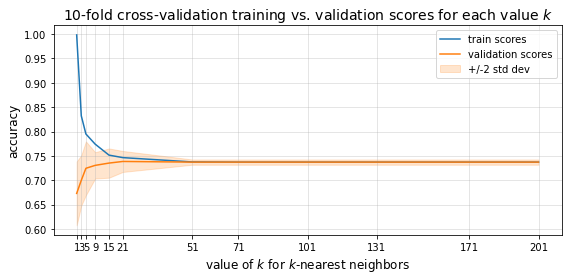

The best value 'k' is 21 with a mean validation score of 0.7386


The classification accuracies for 'knn_model' where k=21 are:

	Train	0.7440
	TEST	0.7013


In [22]:
# your code here
fig, ax = plt.subplots(figsize=(8, 4))
plt.title(
    f"{folds}-fold cross-validation training vs. "
    "validation scores for each value $k$",
    fontsize=14,
)
plt.plot(ks, train_score, label="train scores")
plt.plot(ks, validation_score, label="validation scores")
plt.fill_between(
    ks,
    validation_score+2*validation_var,
    validation_score-2*validation_var,
    color="tab:orange",
    alpha=0.2,
    label="+/-2 std dev"
)
plt.grid(":", alpha=0.4)
plt.xlabel("value of $k$ for $k$-nearest neighbors", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.xticks(ks)
plt.legend()
plt.tight_layout()
plt.show()

print(
    "The best value 'k' is {} with a mean validation score "
    "of {:.4f}\n\n".format(best_k, max(validation_score))
)


# fit best model on the training data and report results

knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(
        X=X_train[predictor_list].values,
        y=y_train.values,   
)

accuracy_train_knn_model = knn_model.score(
    X_train[predictor_list].values, y_train
)
accuracy_test_knn_model = knn_model.score(
    X_test[predictor_list].values, y_test
)

print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        best_k, accuracy_train_knn_model, accuracy_test_knn_model
    )
)

# create dict for storing test scores for each Q4 model
q4_test_scores = {
    "knn_model": accuracy_test_knn_model
}

<div class='exercise-r'>

**4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Print out the coefficient estimates and report the classification accuracy on train and test for this model.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [23]:
# your code here
max_iter = 1000
penalty = "none"

logit_full = LogisticRegression(penalty=penalty, max_iter=max_iter).fit(
    X_train[predictor_list].values, y_train.values
)

logit_full_coefs = logit_full.coef_[0]
logit_full_intercept = logit_full.intercept_

accuracy_train_logit_full = logit_full.score(
    X_train[predictor_list].values, y_train
)
accuracy_test_logit_full = logit_full.score(
    X_test[predictor_list].values, y_test
)

print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit_full_intercept[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit_full, accuracy_test_logit_full)
)

# store test score to dict for later use
q4_test_scores["logit_full"] = accuracy_test_logit_full

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7090
	test                0.7838
	ap                  -0.1403
	avg_ap              0.0975
	sat_subjects        -0.0952
	gpa                 0.1056
	female              0.0518
	minority            0.9165
	international       0.4500
	sports              1.2334
	harvard             0.2581
	early_app           0.3737
	alumni              0.6629

The classification accuracies for 'logit_full' are:

	Train	0.7453
	TEST	0.7147


<div class='exercise-r'>

**4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric.  Print out the coefficient estimates and report the classification accuracy on train and test for this model.

</div>

In [24]:
# your code here
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 1000
penalty = "l1"
solver = "liblinear"

logit_lasso = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver
).fit(
    X_train[predictor_list].values, y_train.values
)

logit_lasso_coefs = logit_lasso.coef_[0]
logit_lasso_intercept = logit_lasso.intercept_

accuracy_train_logit_lasso = logit_lasso.score(
    X_train[predictor_list].values, y_train
)
accuracy_test_logit_lasso = logit_lasso.score(
    X_test[predictor_list].values, y_test
)

print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit_lasso_intercept[0]
    )
)

for predictor, coef in zip(predictor_list, logit_lasso_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit_lasso, accuracy_test_logit_lasso)
)

# store test score to dict for later use
q4_test_scores["logit_lasso"] = accuracy_test_logit_lasso

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.7014
	test                0.7819
	ap                  -0.1388
	avg_ap              0.0952
	sat_subjects        -0.0943
	gpa                 0.1045
	female              0.0493
	minority            0.9121
	international       0.4403
	sports              1.2214
	harvard             0.2545
	early_app           0.3702
	alumni              0.6563

The classification accuracies for 'logit_lasso' are:

	Train	0.7453
	TEST	0.7147


<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Please remember that, as a general practice, zero-value Lasso coefficients (i.e. $\beta_i=0$) are considered "unimportant".
 
</div>

In [25]:
# your code here
bool_important_coefs = (logit_lasso_coefs != 0)
predictors_important = list(
    np.array(predictor_list)[bool_important_coefs]
)

print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        np.array(predictor_list)[~bool_important_coefs],
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'international', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	[]


<div class='exercise-r'>

**4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `logit_lasso_interact`).  Again use `Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]` and 10-fold cross-validation with classification accuracy as the scoring metric. Report the classification accuracy on train and test for this model.

</div>

In [26]:
# your code here

# To create our interaction terms, we need n choose 2
# combinations of predictors, where n represents
# the important predictors from 4.5

# There are several efficient ways to create
# these n choose 2 combinations of predictors in order
# to generate our interactions terms (being certain
# to NOT create duplicates, such as ap * test AND test * ap).

# To illustrate, below are 3 EXAMPLE METHODS for completing
# this task.

# The results from all 3 of these methods will be identical.

## EXAMPLE METHOD 1:
## we could do this using purely PolynomialFeatures by
## setting `interaction_only=True`, then creatively using
## `.get_feature_names()` to correctly name each interaction
## feature column in X_train and X_test.

Poly = PolynomialFeatures(
    interaction_only=True, include_bias=False
).fit(X_train[predictors_important])

all_colnames = Poly.get_feature_names(predictors_important)

X_train[all_colnames] = Poly.transform(X_train[predictors_important])
X_test[all_colnames] = Poly.transform(X_test[predictors_important])

# create interaction_colnames list to be consistent with other 2 examples
interaction_colnames = [
    col for col in all_colnames
    if col not in predictors_important
]

## EXAMPLE METHOD 2:
## As a different approach, we could use `itertools` which
## is included as part of the Python standard library and use
## `itertools.combinations` function to generate our
## interaction term combinations. See the docs here:
## https://docs.python.org/3/library/itertools.html#itertools.combinations

combinations = list(
    itertools.combinations(predictors_important, 2)
)

interaction_colnames = []

for a, b in combinations:
    colname = '{} {}'.format(a, b)
    X_train[colname] = X_train[a] * X_train[b]
    X_test[colname] = X_test[a] * X_test[b]
    interaction_colnames.append(colname)

## EXAMPLE METHOD 3:
## we could use pure Numpy to generate our n choose 2 combinations
## using an interesting function called `np.triu_indices` which
## returns the indices for the upper-triangle of an (n, m) array.
## See the docs here:
## https://numpy.org/doc/stable/reference/generated/numpy.triu_indices.html

# convert list to array
pred_import_array = np.array(predictors_important)

# use triu_indices to generate pairwise indices arrays
j, k = np.triu_indices(len(predictors_important), 1)

# generate 2d array of n choose 2 combinations using indices
combinations = np.stack(
    [pred_import_array[j], pred_import_array[k]]
).T

# generate interaction term predictors
interaction_colnames = []

for a, b in combinations:
    colname = "{} {}".format(a, b)
    X_train[colname] = X_train[a] * X_train[b]
    X_test[colname] = X_test[a] * X_test[b]
    interaction_colnames.append(colname)

In [27]:
# your code here

logit_lasso_interact_predictors = predictors_important + interaction_colnames
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 1000
penalty = "l1"
solver = "liblinear"

logit_lasso_interact = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver
).fit(
    X_train[logit_lasso_interact_predictors].values, y_train.values
)

logit_lasso_interact_coefs = logit_lasso_interact.coef_[0]
logit_lasso_interact_intercept = logit_lasso_interact.intercept_

accuracy_train_logit_lasso_interact = logit_lasso_interact.score(
    X_train[logit_lasso_interact_predictors].values, y_train
)
accuracy_test_logit_lasso_interact = logit_lasso_interact.score(
    X_test[logit_lasso_interact_predictors].values, y_test
)

print(
    "The intercept and coefficients for the 'logit_lasso_interact' model are:"
    "\n\n\t{:<30}{:.4f}".format(
        "intercept", logit_lasso_interact_intercept[0]
    )
)

for predictor, coef in zip(logit_lasso_interact_predictors, logit_lasso_interact_coefs):
    print("\t{:<30}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit_lasso_interact, accuracy_test_logit_lasso_interact)
)

print()

# store test score to dict for later use
q4_test_scores["logit_lasso_interact"] = accuracy_test_logit_lasso_interact

The intercept and coefficients for the 'logit_lasso_interact' model are:

	intercept                     -1.6283
	test                          0.5699
	ap                            0.0704
	avg_ap                        -0.1044
	sat_subjects                  -0.0094
	gpa                           0.1360
	female                        -0.1208
	minority                      1.3332
	international                 0.0000
	sports                        1.4552
	harvard                       0.0780
	early_app                     0.3843
	alumni                        0.0266
	test ap                       -0.0490
	test avg_ap                   0.0049
	test sat_subjects             -0.0636
	test gpa                      0.1295
	test female                   0.0805
	test minority                 0.0969
	test international            0.1746
	test sports                   0.0000
	test harvard                  0.2355
	test early_app                -0.3674
	test alumni                   1.0987
	ap avg

<div class='exercise-r'>

**4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? (Feel free to just report on the number of them found to be important and unimportant. There is no need to list them all here.)
    
</div>

In [28]:
# your code here
number_coefs = len(logit_lasso_interact_coefs)
number_important_coefs = sum(logit_lasso_interact_coefs != 0)
number_unimportant_coefs = number_coefs - number_important_coefs 

print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        number_coefs, number_important_coefs, number_unimportant_coefs
    )
)

Of the 78 predictors used in our 'logit_lasso_interact' model:

	60 predictors were deemed 'important' by our model
	18 predictors were deemed 'unimportant' with 0-valued coefficients


---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results [12 pts]</div>

[Return to contents](#contents)

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?


<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1** Which of the 4 models in Question 4 performs the best based on classification accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [29]:
# your code here
print("The TEST accuracies for the 4 models in Q4 are:\n")
for key, value in q4_test_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe TEST accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(accuracy_naive_model_test)
)

The TEST accuracies for the 4 models in Q4 are:

	knn_model                0.7013
	logit_full               0.7147
	logit_lasso              0.7147
	logit_lasso_interact     0.7040

The TEST accuracy for our original baseline "naive" model was 0.7013


**INTERPRETATION:**

*your answer here*

Students should be evaluating the best/worst models based on these test accuracies, which should in turn be compared to the naive model. The "naive" model accuracy compared here must be reflective of the TEST accuracy of that naive model (not the training accuracy). We should NOT see very large improvements over the naive model, even with our best models `logit_full` and `logit_lasso`. This tells us that, regardless of all the work we have done, we have gained very limited predictive improvement over simply predicting ALL applicants as being "not admitted". In fact, with the `knn_model`, we have gained no improvement in accuracy over our naive model.

<div class='exercise-r'>

**5.2** Draw the four ROC curves on the same set of axes using the test data.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?
    
</div>

In [30]:
# your code here
# save list of model names for dictionary keys and plotting
model_names = list(q4_test_scores.keys())
predictor_sets = [predictor_list]*3 + [logit_lasso_interact_predictors]

# save predicted probabilities for each corresponding model for
# converting to fpr, tpr, and thresholds in roc_curve function
models_roc_predictions = [
    globals()[model_name].predict_proba(X_test[predictors])
    for model_name, predictors in zip(model_names, predictor_sets)
]

In [31]:
# your code here
# save list of model names for dictionary keys and plotting
model_names = list(q4_test_scores.keys())
predictor_sets = [predictor_list]*3 + [logit_lasso_interact_predictors]

# save predicted probabilities for each corresponding model for
# converting to fpr, tpr, and thresholds in roc_curve function
models_roc_predictions = [
    globals()[model_name].predict_proba(X_test[predictors])
    for model_name, predictors in zip(model_names, predictor_sets)
]

# calculate fpr, tpr, and thresholds for each model and store in dict
roc_curves_dict = {
    model_name: {
        key: value
        for key, value in zip(
            ["fpr", "tpr", "thresholds"],
            roc_curve(y_test, predicted_probabilities[:,1])
        )
    }
    for model_name, predicted_probabilities in zip(
    model_names, models_roc_predictions)
}

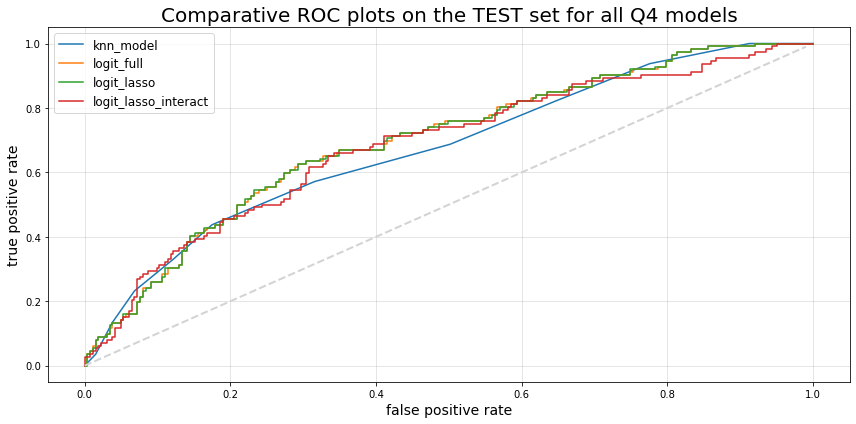

In [32]:
# your code here
rate_values=np.arange(0,100)/100

# generate comparative ROC plots for each model
fig, ax = plt.subplots(figsize=(12, 6))

plt.title(
    "Comparative ROC plots on the TEST set for all Q4 models",
    fontsize=20,
)

for fpr, tpr, model_name in zip(
    [roc_curves_dict[model_name]["fpr"] for model_name in model_names],
    [roc_curves_dict[model_name]["tpr"] for model_name in model_names],
    model_names,
):
    ax.plot(fpr, tpr, linewidth=1.5, label=model_name)
    ax.set_ylabel("true positive rate", fontsize=14)
    ax.set_xlabel("false positive rate", fontsize=14)

plt.plot(rate_values, rate_values, "--", color="lightgray", linewidth=2, alpha=1)

plt.legend(fontsize=12)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show()

**INTERPRETATION:**

*your answer here*

Students should compare the ROC curves based on the perceived area under the curve and/or the distance from the equilibrium line. The ROC curves appear very similar, so it is difficult to make a definitive choice based on these alone. However, in general, these curves do appear to be reflective of the best and worst models identified in Question 5.1. Both `logit_full` and `logit_lasso` appear to be closely matched with the greatest area under the ROC curve and the `knn_model` ROC curve appears to exhibit the least area beneath it.

It is also important to demonstrate an understanding of how the ROC curve relates to or illustrates model performance. For instance, it is notable that none of these ROC curves are particularly demonstrative of the visual upper-left elbow we'd like to see in an ROC curve. If it existed, such an elbow would be indicative of an opportunity to maximize our true positive rate (TPR) with a limited trade-off in false positive rate (FPR) by modifying our classification threshold to something other than $\hat{p}>0.5$. 

<div class='exercise-r'>

**5.3** Calculate and report AUC for all 4 models.  Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

In [33]:
# your code here
# calculate each model's AUC using its ROC fpr and tpr
auc_list = [
    roc_auc_score(
        y_test,
        predicted_probabilities[:,1],
    )
    for predicted_probabilities in models_roc_predictions
]


print(
    "The TEST accuracies vs. AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_test_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The TEST accuracies vs. AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7013		0.6742
	logit_full              0.7147		0.6965
	logit_lasso             0.7147		0.6965
	logit_lasso_interact    0.7040		0.6826


**INTERPRETATION:**

*your answer here*

AUC scores should relate to how the ROC curves appear. They are also NOT always expected to rank the performance of different classification models in the same relative order as accuracy might rank them (however they do rank them in the same order for us here). Because AUC is based on our ROC curves, it offers a metric that evaluates the performance of our models as we vary our classification threshold, thus helping us to quantify the model's ability to maximize TPR with minimal cost to FPR based on ALL possible thresholds. Therefore, AUC measures performance in a very different manner than accuracy, which is just measuring the accuracy of our model at a single $\hat{p}>0.5$ threshold.

<div class='exercise-r'>

**5.4** If you were to use one of these 4 models to present as a prediction model for the website [collegedata.com](https://www.collegedata.com/), which would you use and why?  What may be the biggest issue if this was a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale?
    
</div>

*your answer here*

The model with the highest AUC score likely generalizes best. However, since none of the test accuracies showed a dramatic improvement over the naive model, these models likely would not provide much of a service to prospective students, particularly if the output is an "admitted"/"not admitted" output. Far more informative would be a model that outputs the probability of admission (rather than a predicted class). Such an output would be far less misleading to prospective applicants, particularly with an imbalanced data set such as this one.

However, based on other results we have seen throughout this problem-set (such as the improbable decision boundaries) there are likely other issues with using these modeling approaches to predict admission based on the available dataset. Students can once again point out the nature of the data that we trained on, particularly the self-reported and biased nature of it, indicating that any modeling approach will itself be biased due to the biased input data. Therefore, our collegedata.com predictive modeling tool will not be reflective of an applicant's/website user's actual probability of admission to either of these schools. In addition, this dataset and associated models completely omit other important factors taken into consideration during admissions for both of these schools, such as the quality of student essays and interviews, and other qualitative factors not captured here.

#### THE END

[Return to contents](#contents)